## Retrieve the DNA sequeces from Ensembl using REST API
#### Upregulated genes by IFN (Positive Contorl)
#### Not regulated genes by IFN (Negative control)

#### Parse the positive control file and extract the gene_id, gene_name
#### Generate FASTA file

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

positive_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_IFN_up-regulation.csv"

with open(positive_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("Promoter_sequences_positive_control.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}")
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.
>MX1_ENSG00000157601
AATGAAATAATGGCATTCACAGCAACCTGGATGGAGTTGGAGACCATTATTCTAAGTGAAGTAACTCGGGAATAAAAACCAAACATTGTATATTCTCACTCATAAGTGAGATTATACAAGCTATGAGGATGCAAAGTCATAAGAATGATACAATAAACATTGGGAACTCAGGGGGAAGGGTGAGGGTGGGGTGAGGGATAAAAGACTAGACATCGGGTACAGTATACACTGCTTGGGTGATGGGTGCACCAAAATCCCAGAAATCACGATTAAAGAACTTGTCAATGTAACCAAACACCACCTGTTCCTCAAAAACTATTGAAATAAAAAATAAATACATAAAAGAAGTTGAGGTTAAATTAATCTAAGTAGGGAGTGCATTTGGGCCAAGCTTGAGGATTGCAACGTTGGAGCACAGATTTAAGTTGCCCTGAATCTACACTCTGATAAGTGGCATTTATAAGTGGATTTTTAAAGGCAAAAGGGGGAGACAGGGAGAGGGCTGATACAAAGCTGTTTGTCAGGAATTCTTATTGGTTTACAGAAATAACATTGATAAGTGCTTATTAGTCCATTTTCATGCTGCTGATAAAGACATACCTCAGACTGGGCAATTTACAAAAGAAAGAGGTTTATTGGACCTATAGTTCCACATGGCTGAGGAGGCCTCACAATCATGGTGGAAGGCAAGGAGGAGCAAGTCACATCTTACATGGATGACAGCAGGAAAAAAGAGAGAGCTTGTGCAGAGAAACTCCCTTTTTTAAAACCATCAGATCTTGTGAGACCCGTTCAGGATCATGAGAACAGCACAGGAAAGACCCACCCCCAAGATTCAATCATCTCCCACCGGGTCTCTCCCACAACATGAGTGAATTATGGGAGCTACAGGATGAGATTTGGGTGAGGACACAGAGCCAAACCAT

## Scan motif in Promoter Region

In [10]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_positive_threshold_10.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_positive_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=10.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_positive_threshold_10.0.csv


## Retrieve the negative control genes sequence from Ensembl using REST API

In [12]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

negative_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_no_IFN_regulation.csv"

with open(negative_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("Promoter_sequences_negative_control.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}")
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.


In [25]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_negative_threshold_9.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_negative_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=9.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_negative_threshold_9.0.csv


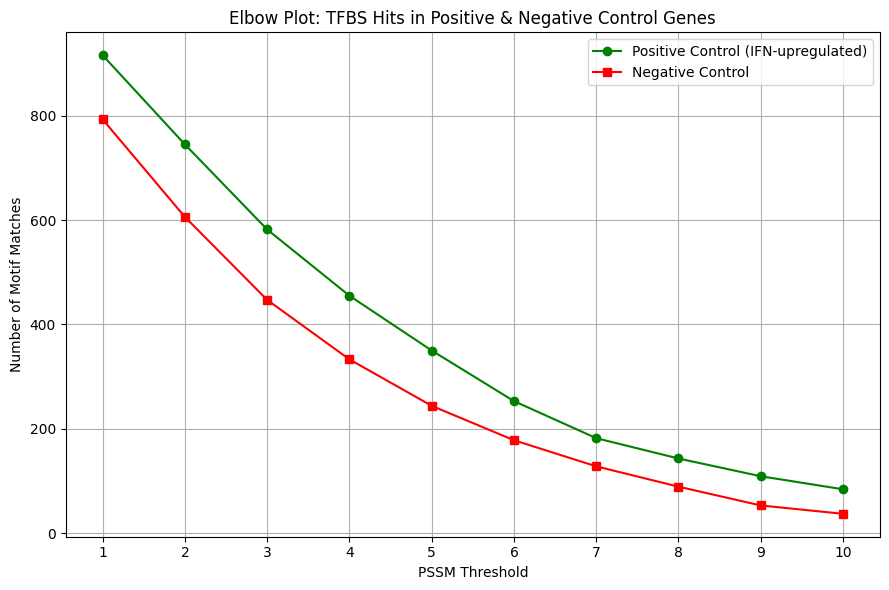

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define base paths
positive_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-1/outputs/positive"
negative_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-1/outputs/negative_con"

# Thresholds to evaluate
thresholds = range(1, 11)

# Empty lists to hold match counts
pos_hits = []
neg_hits = []

# Loop through thresholds
for threshold in thresholds:
    # Positive control output files
    pos_file = os.path.join(positive_path, f"motif_scan_positive_threshold_{threshold}.0.csv")
    if os.path.exists(pos_file):
        df_pos = pd.read_csv(pos_file)
        pos_hits.append(len(df_pos))
    else:
        pos_hits.append(0)

    # Negative control output files
    neg_file = os.path.join(negative_path, f"motif_scan_negative_threshold_{threshold}.0.csv")
    if os.path.exists(neg_file):
        df_neg = pd.read_csv(neg_file)
        neg_hits.append(len(df_neg))
    else:
        neg_hits.append(0)

# Plot both lines
plt.figure(figsize=(9, 6))
plt.plot(thresholds, pos_hits, marker='o', label="Positive Control (IFN-upregulated)", color="green")
plt.plot(thresholds, neg_hits, marker='s', label="Negative Control", color="red")

plt.xlabel("PSSM Threshold")
plt.ylabel("Number of Motif Matches")
plt.title("Elbow Plot: TFBS Hits in Positive & Negative Control Genes")
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()